In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
import random
import os
import vaex
from utils import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [5]:
%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = 30, 10

# Load Binance Data

In [6]:
BINANCE_DATA_PATH = 'data/binance/'

In [7]:
TOP_MKT_CAP = ['BTC', 'ETH', 'BNB', 'XRP', 'DOGE', 'ADA', 'MATIC', 'DOT', 'TRX']

data_raw = {}

# load data using pandas for each coin in TOP_MKT_CAP and store in data_raw
for coin in TOP_MKT_CAP:
    data_raw[coin] = pd.read_parquet(os.path.join(BINANCE_DATA_PATH, f'{coin}-USDT.parquet'))


In [8]:
data_raw['BTC'].head()

,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
open_time,,,,,,,,,
2017-08-17 04:00:00,4261.479980,4261.479980,4261.479980,4261.479980,1.775183,7564.906738,3,0.075183,320.390839
2017-08-17 04:01:00,4261.479980,4261.479980,4261.479980,4261.479980,0.000000,0.000000,0,0.000000,0.000000
2017-08-17 04:02:00,4280.560059,4280.560059,4280.560059,4280.560059,0.261074,1117.542969,2,0.261074,1117.542969
2017-08-17 04:03:00,4261.479980,4261.479980,4261.479980,4261.479980,0.012008,51.171852,3,0.012008,51.171852
2017-08-17 04:04:00,4261.479980,4261.479980,4261.479980,4261.479980,0.140796,599.999329,1,0.140796,599.999329


# Plot candlesticks for each crypto on a random day

In [9]:
mpf.available_styles()

['binance',
 'binancedark',
 'blueskies',
 'brasil',
 'charles',
 'checkers',
 'classic',
 'default',
 'ibd',
 'kenan',
 'mike',
 'nightclouds',
 'sas',
 'starsandstripes',
 'tradingview',
 'yahoo']

2021-12-10
BTC


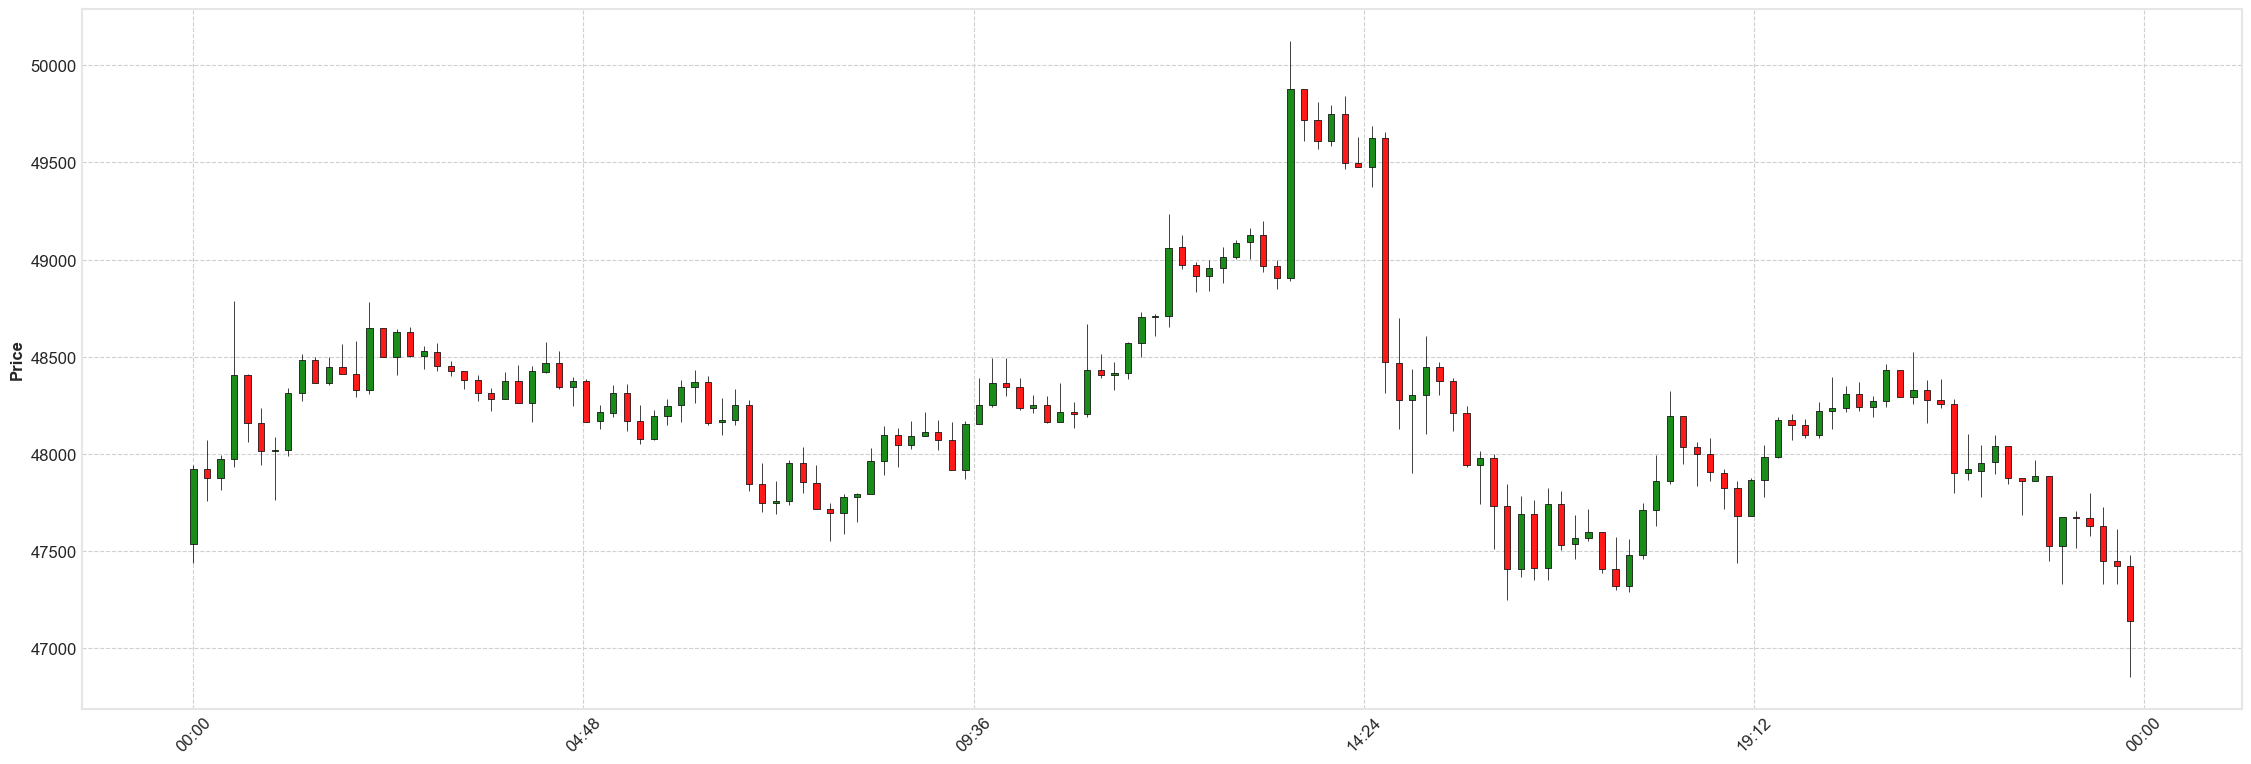

ETH


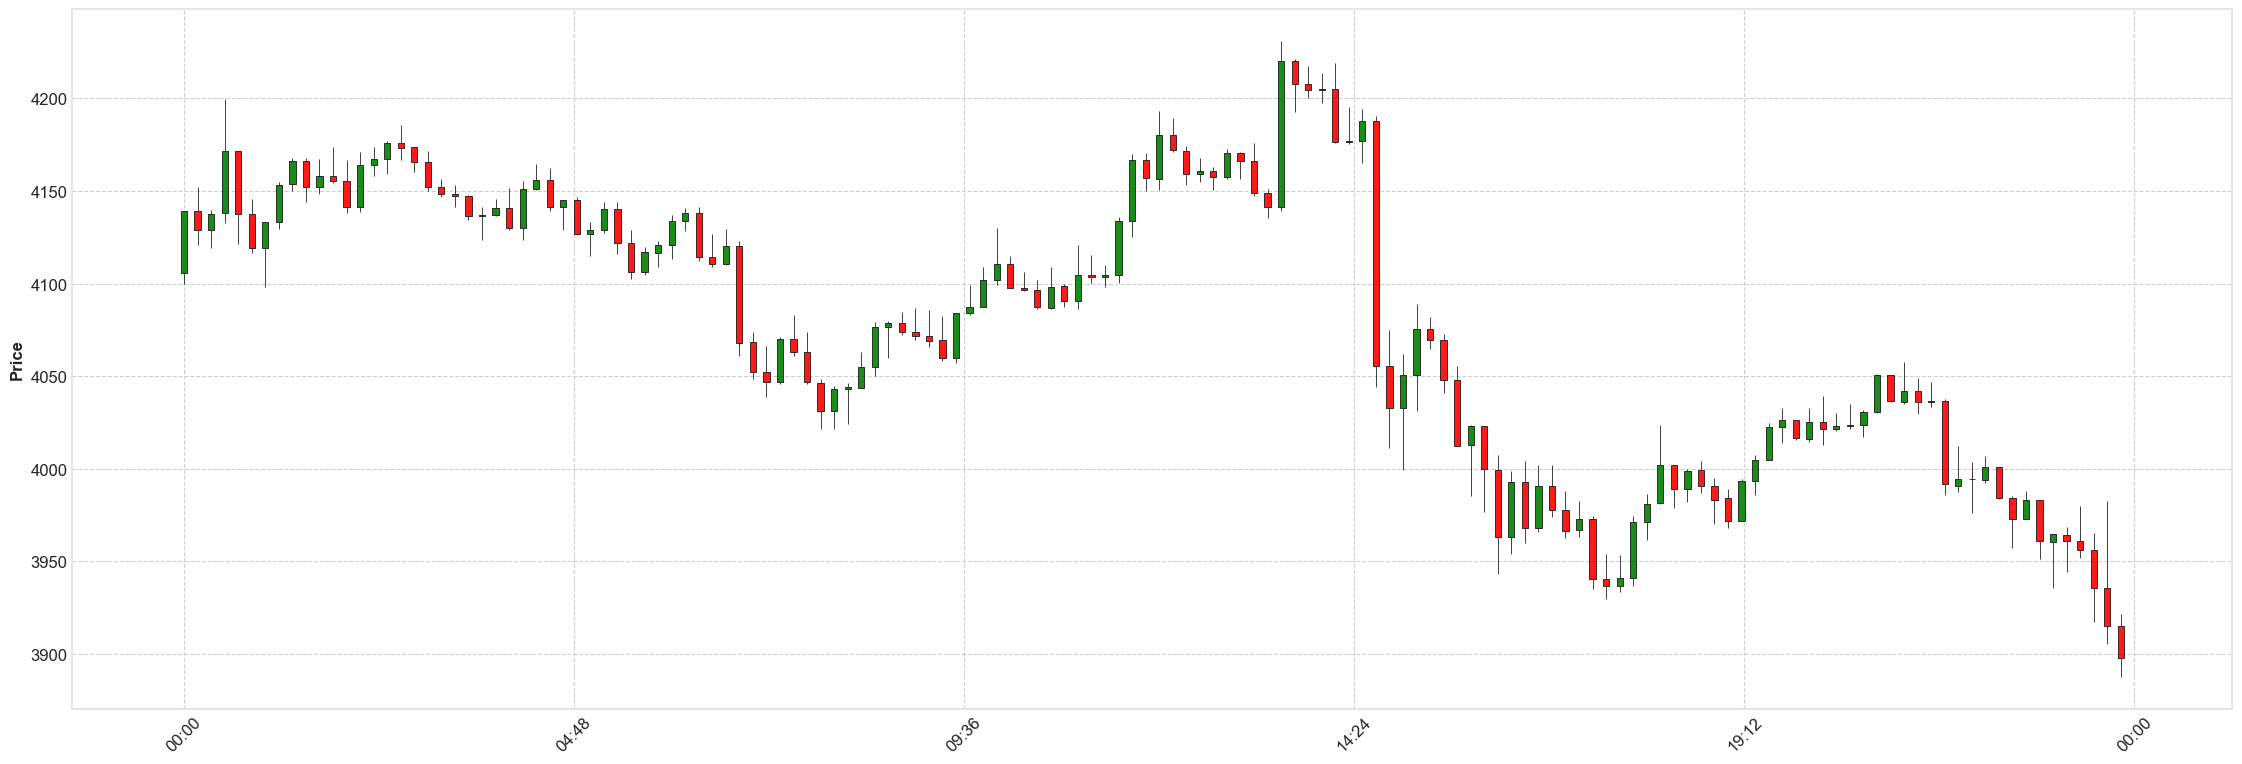

BNB


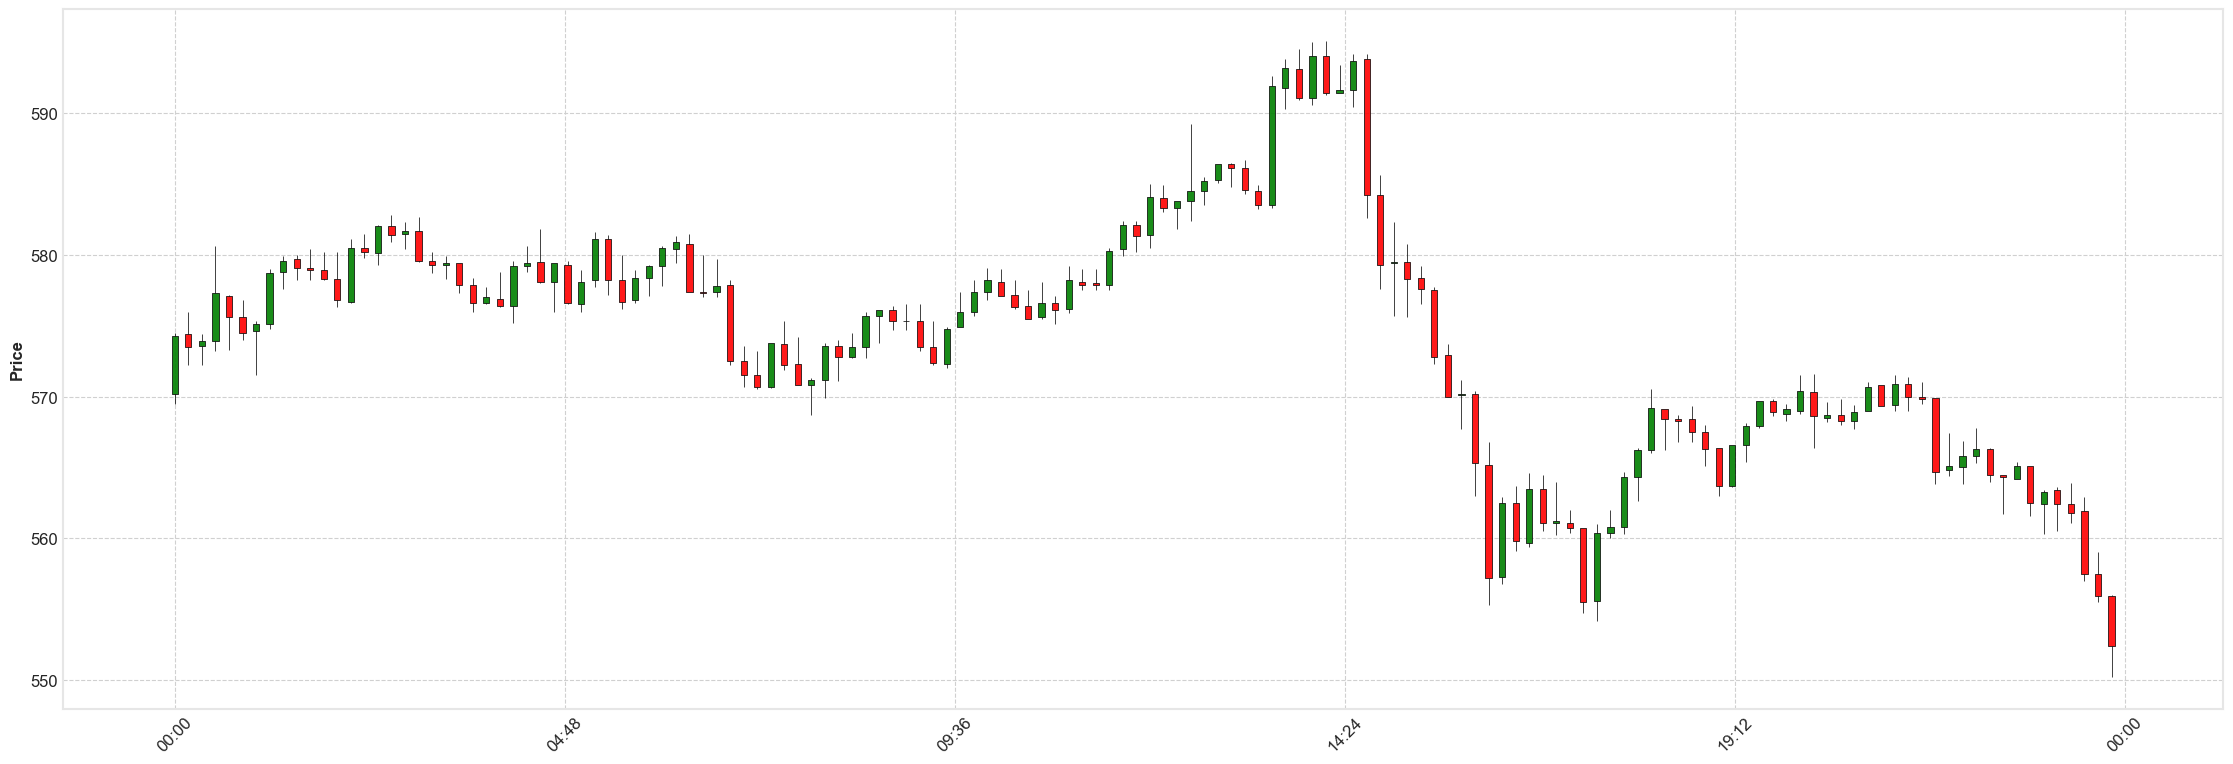

XRP


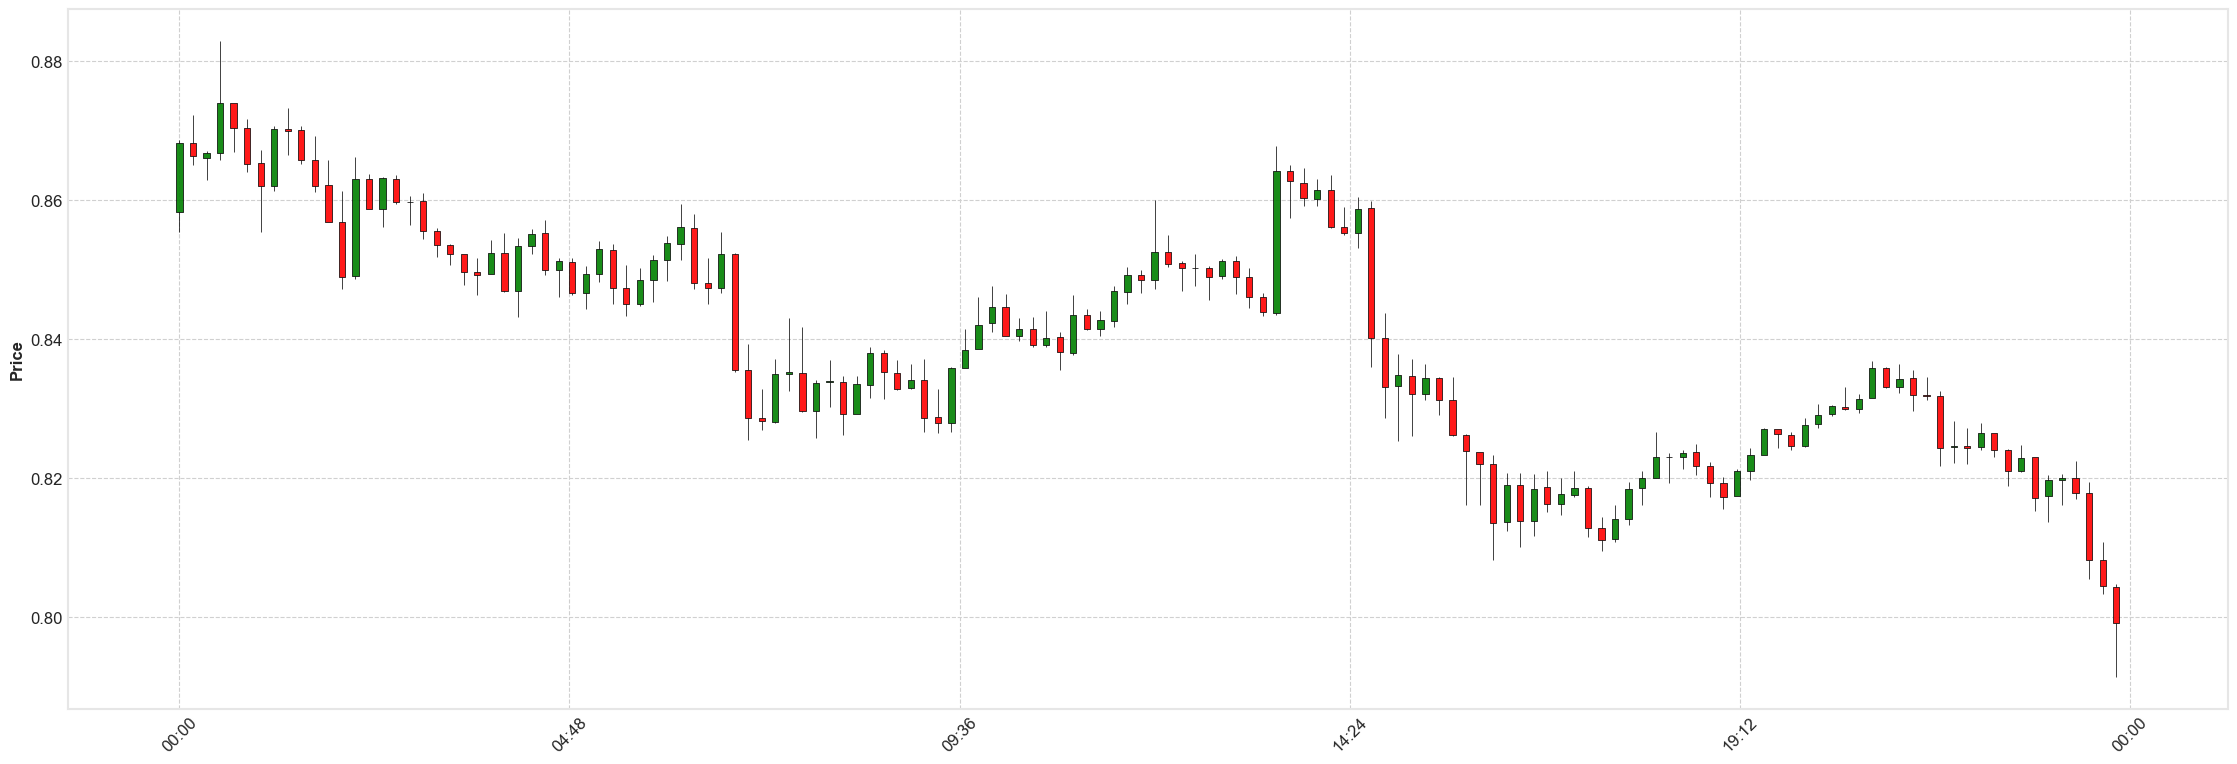

DOGE


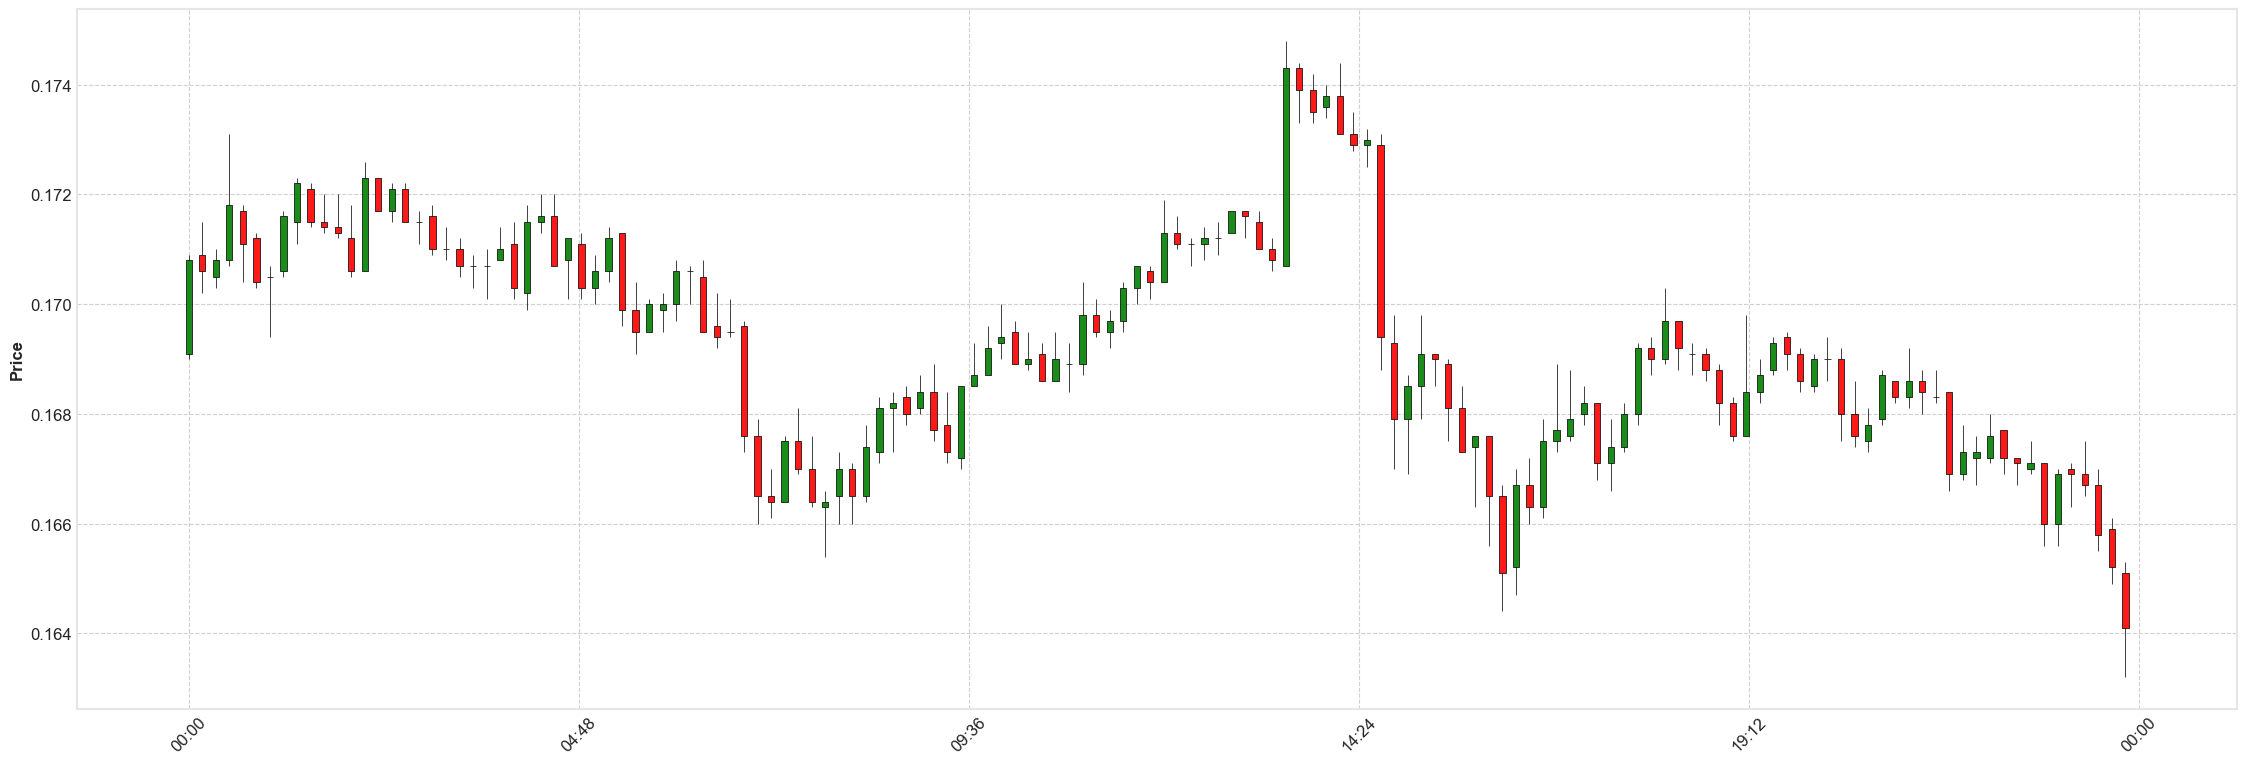

ADA


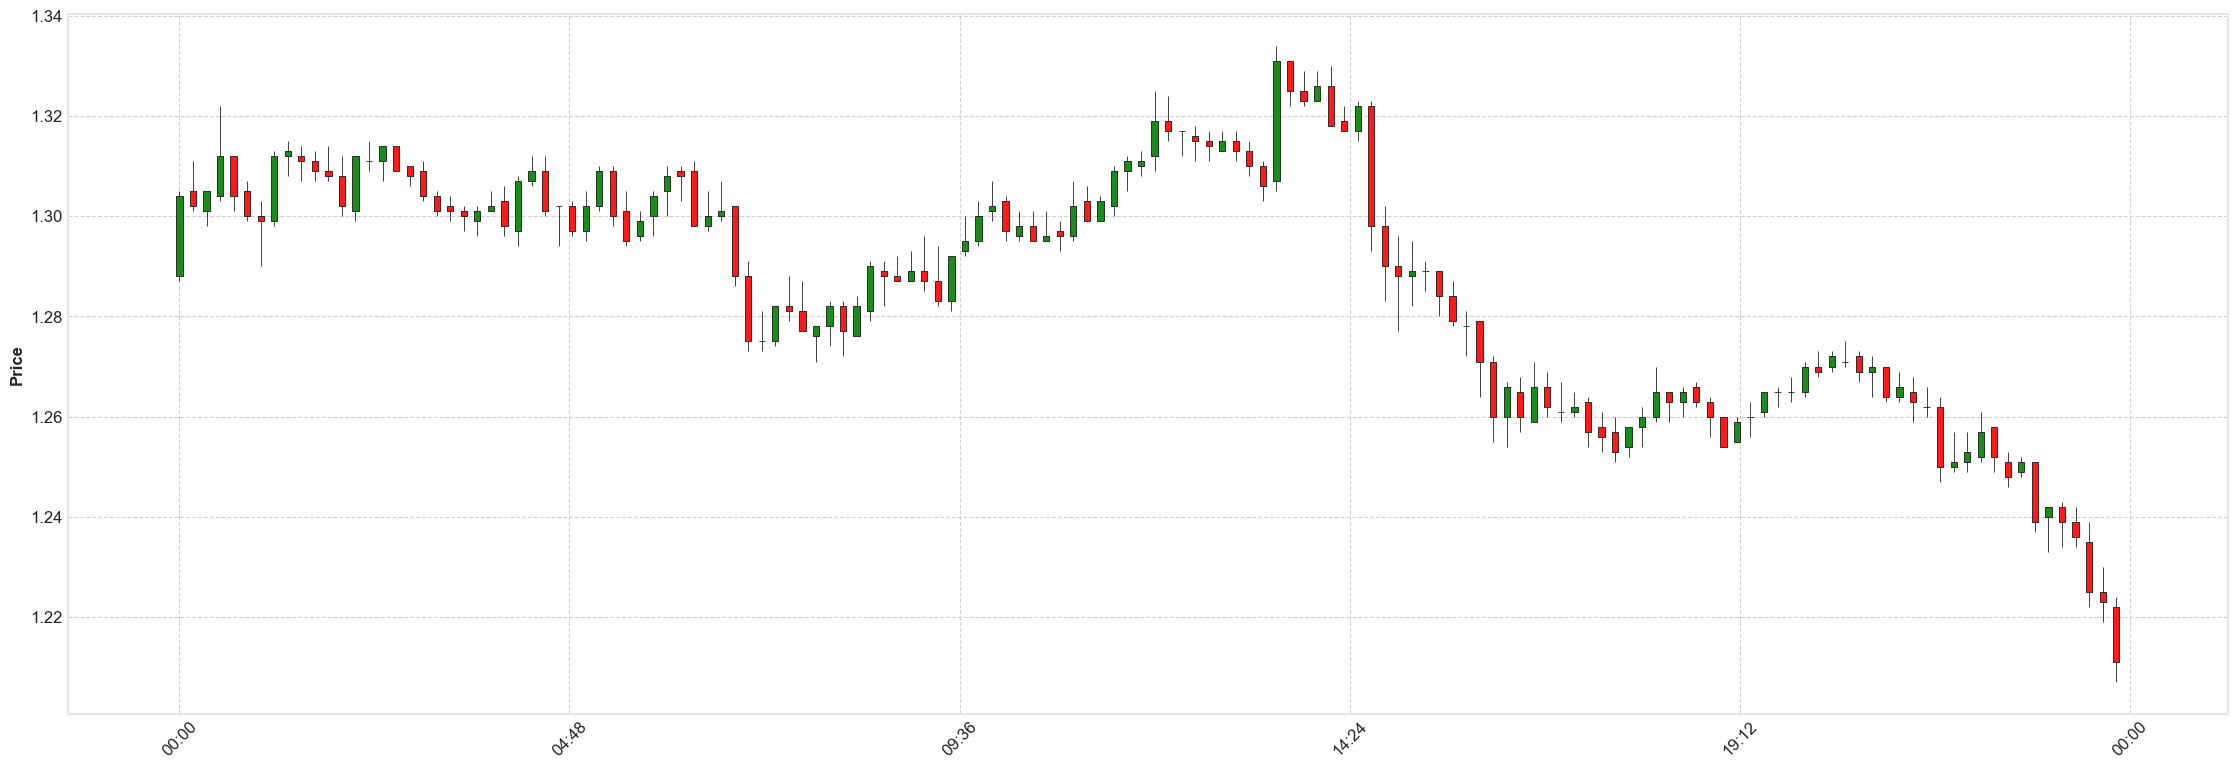

MATIC


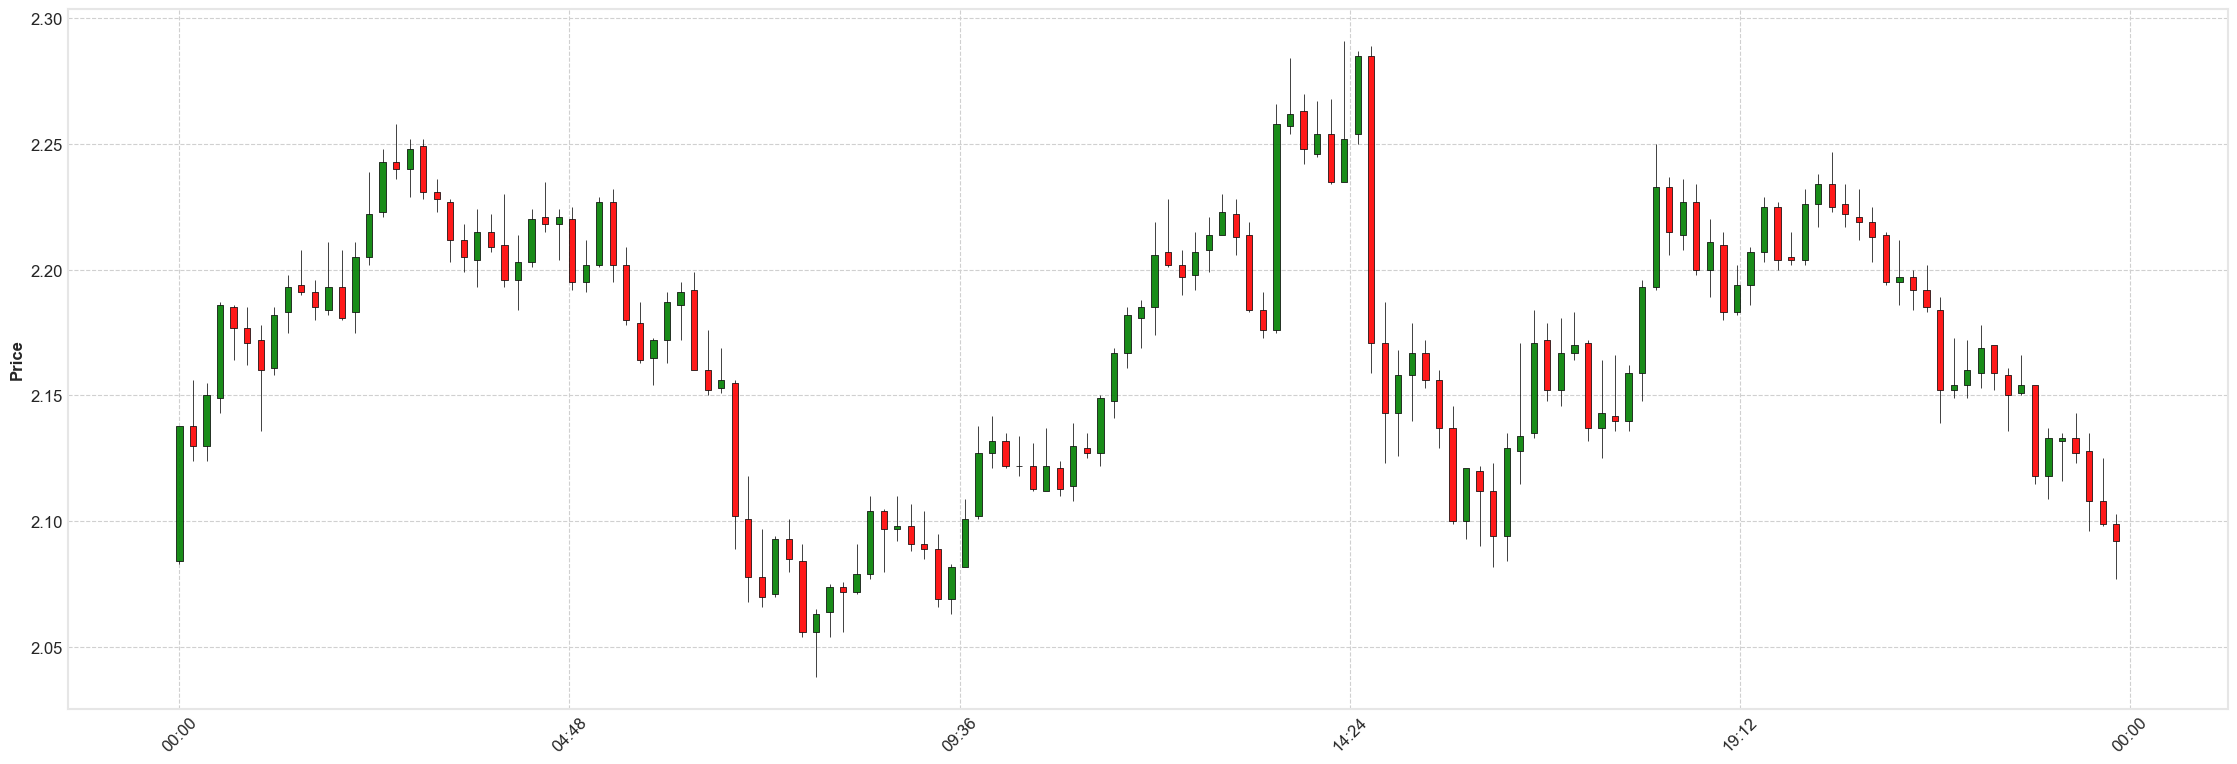

DOT


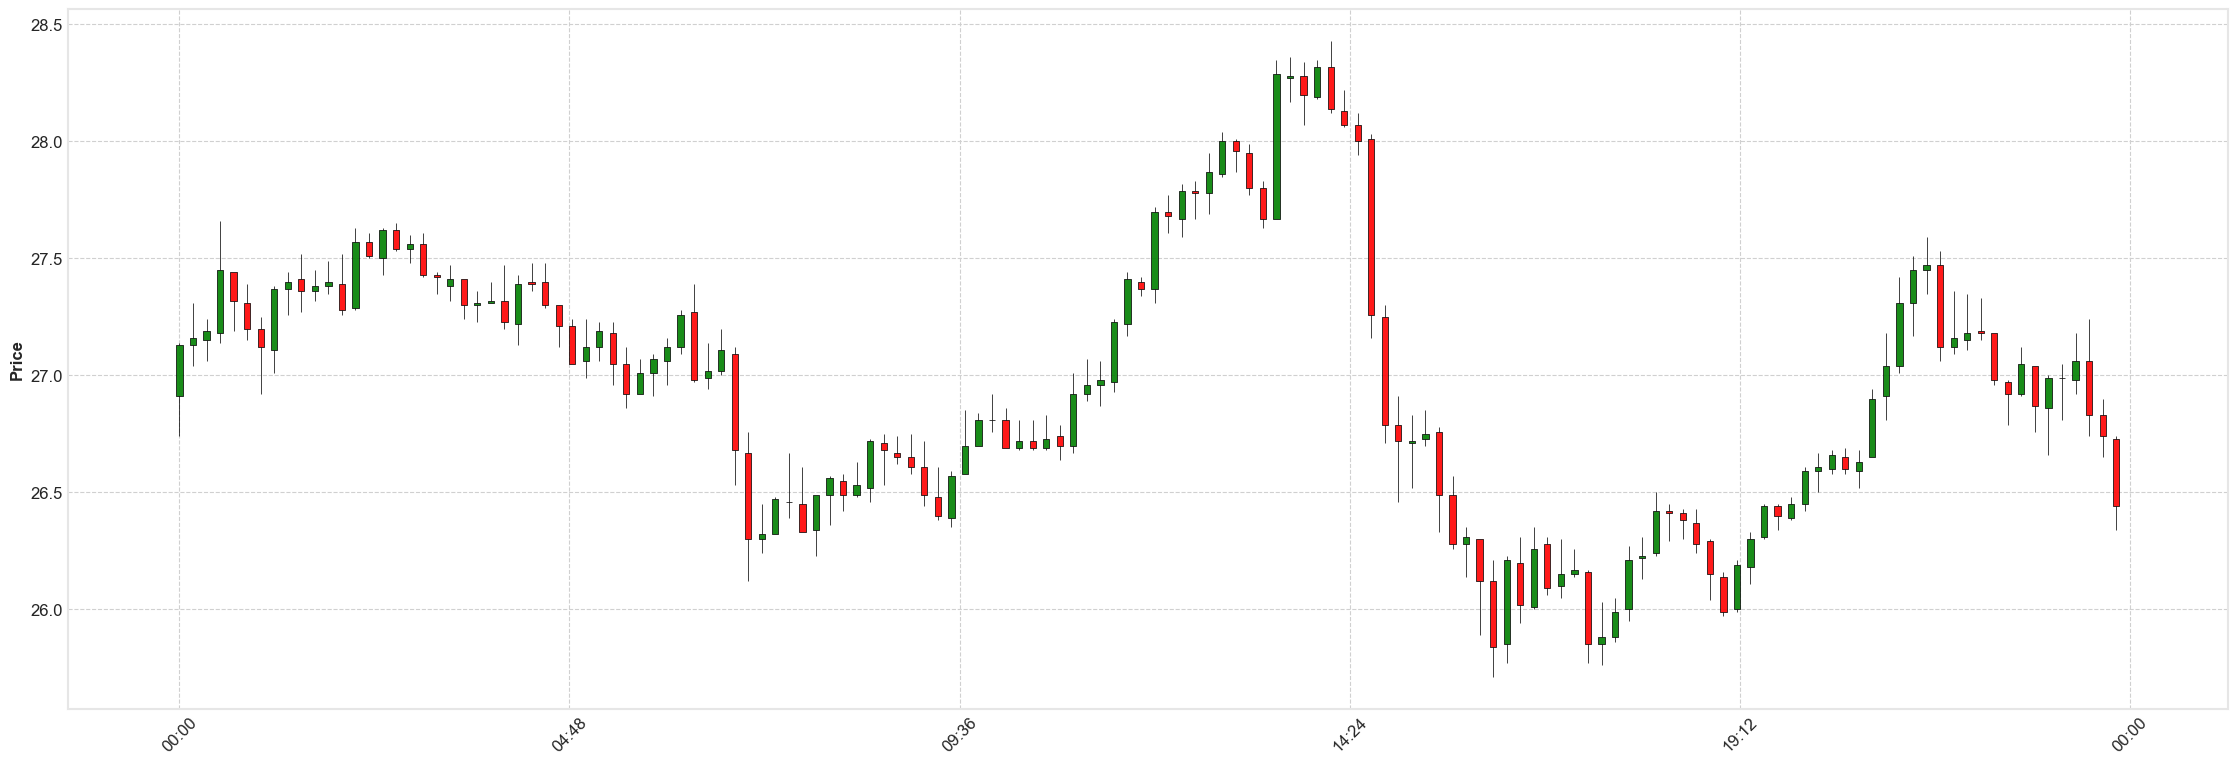

TRX


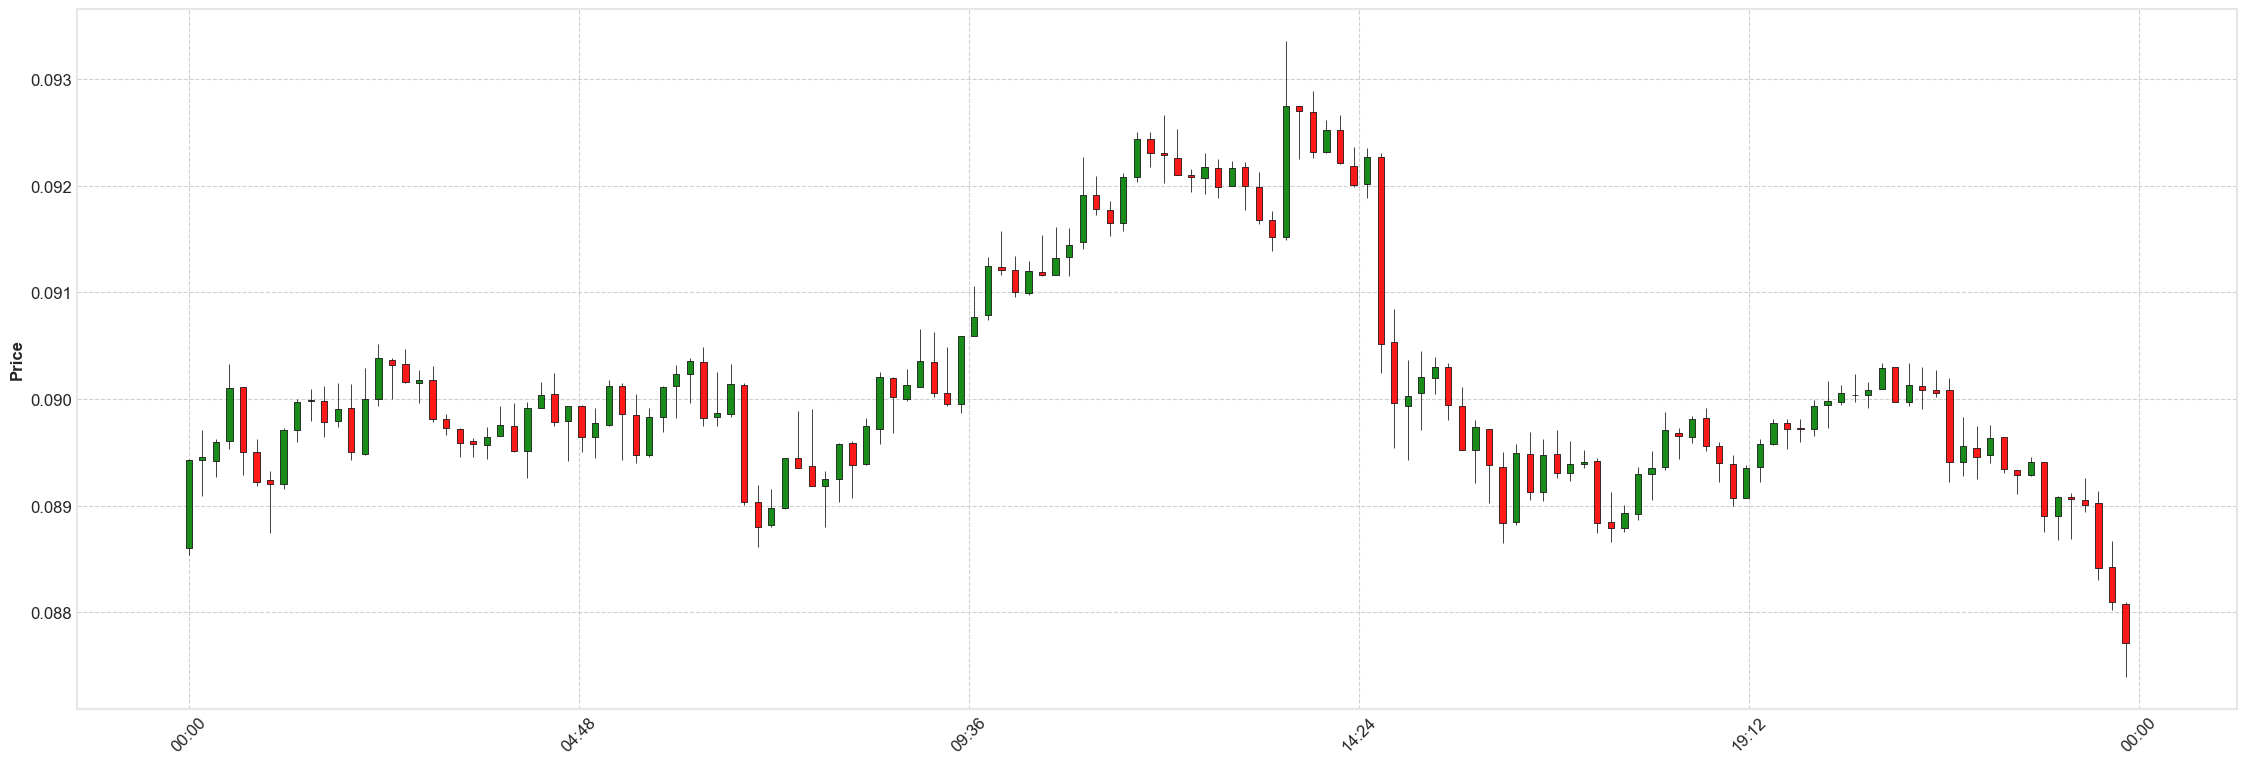

In [18]:
market_colors = mpf.make_marketcolors(up = 'green', down = 'red')
custom_style = mpf.make_mpf_style(base_mpf_style='binance', marketcolors = market_colors, gridstyle = '--', gridaxis = 'both')

# choose a random date in 2021
date = random.choice(data_raw['BTC'].index).date()
print(date)
for coin in TOP_MKT_CAP:
    print(coin)
    data_resampled = data_raw[coin].resample('10T').agg({'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'})
    mpf.plot(data_resampled.loc[str(date)], type='candle', ylabel='Price', style=custom_style, figsize=(30, 10), show_nontrading=True)    



# Correlation

In [13]:
BINANCE_DATA_PATH = "data/binance/"

TOP_MKT_CAP = ['BTC', 'ETH', 'BNB', 'XRP', 'DOGE', 'ADA', 'MATIC', 'DOT', 'TRX']

data_raw = {}
data_hourly = {}

for coin in TOP_MKT_CAP:
    data_raw[coin] = pd.read_parquet(os.path.join(BINANCE_DATA_PATH, coin + "-USDT.parquet"))
    
    data_raw[coin].index = data_raw[coin].index.rename('date')
    # data_raw[coin] = data_raw[coin].reset_index()
    # print(data_raw[coin].index.dtype)
    data_hourly[coin] = resample_data(data_raw[coin], freq='h')

    # compute daily log returns
    data_hourly[coin]['log_ret'] = np.log(data_hourly[coin]['close'] / data_hourly[coin]['open'])

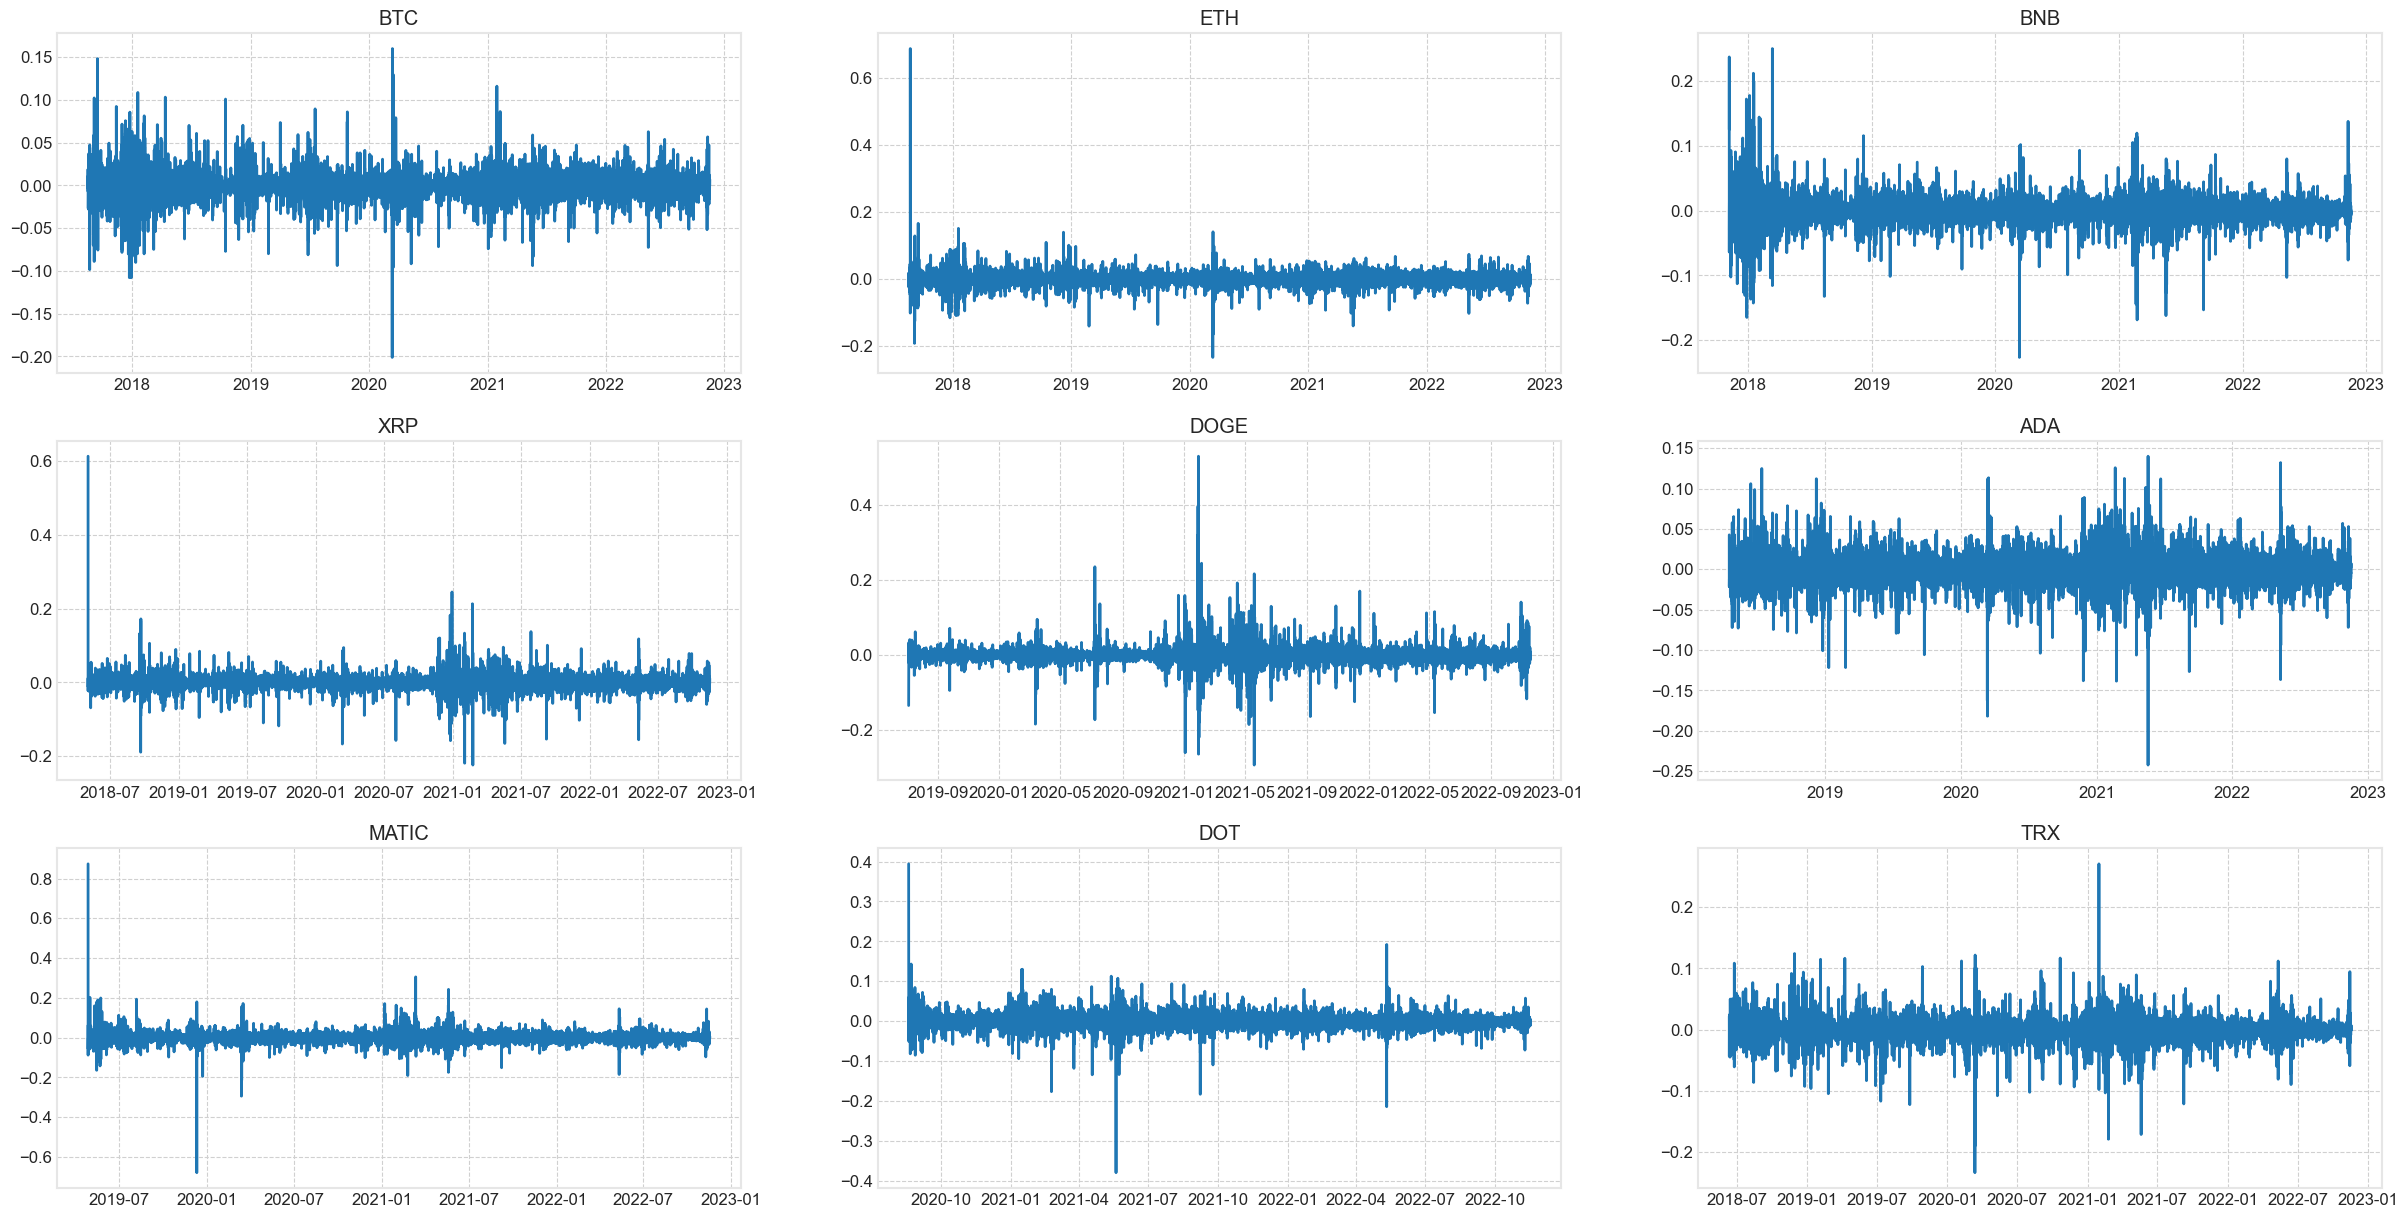

In [14]:
# plot daily log returns
fig, ax = plt.subplots(3, 3, figsize=(30, 15))
ax = ax.flatten()
for i, coin in enumerate(TOP_MKT_CAP):
    ax[i].plot(data_hourly[coin].index, data_hourly[coin]['log_ret'])
    ax[i].set_title(coin)

In [16]:
from tabulate import tabulate

for coin in TOP_MKT_CAP:
    coin_df = data_hourly[coin]
    vol = {}

    for time in ['h', 'D', 'M', 'Y']:
        df_vol = resample_data(coin_df, freq=time)
        df_vol['ret'] = df_vol['close'] / df_vol['open']
        volatility = df_vol['ret'].dropna().std()
        vol[time] = volatility * 100

    print(tabulate([[coin ,vol['h'], vol['D'],vol['M'], vol['Y']]],headers = ['Hourly Volatility %', 'Daily Volatility %', 'Monthly Volatility %', 'Annual Volatility %'],tablefmt = 'fancy_grid',stralign='center',numalign='center',floatfmt=".2f"))
    print()

╒═════╤═══════════════════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│     │  Hourly Volatility %  │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═════╪═══════════════════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ BTC │         0.92          │         4.12         │         23.50          │        150.68         │
╘═════╧═══════════════════════╧══════════════════════╧════════════════════════╧═══════════════════════╛

╒═════╤═══════════════════════╤══════════════════════╤════════════════════════╤═══════════════════════╕
│     │  Hourly Volatility %  │  Daily Volatility %  │  Monthly Volatility %  │  Annual Volatility %  │
╞═════╪═══════════════════════╪══════════════════════╪════════════════════════╪═══════════════════════╡
│ ETH │         1.21          │         5.24         │         31.99          │        240.19         │
╘═════╧═══════════════════════╧══════════════════════╧═════════